In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cartopy.crs as ccrs
import pandas as pd

In [2]:
# get paths. Note the 1.87GB netcdf gebco dataset has been downloaded separate, see README for source info
path_root = os.getcwd()
path_in = os.path.join(os.path.dirname(path_root),'_raw')
path_out = os.path.join(path_root,'subset')

In [3]:
# create an xarray data array from the raw netcdf file
da = xr.open_dataarray(os.path.join(path_in,'GEBCO_2014_2D.nc'))

In [4]:
# print data array metadata for the netcdf
# there are a bunch of properties of the dataarray, like "dims","coords","attrs" amongst others
da

<xarray.DataArray 'elevation' (lat: 21600, lon: 43200)>
[933120000 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.99 -89.98 -89.97 -89.96 -89.95 -89.95 ...
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 -180.0 -180.0 -179.9 ...
Attributes:
    standard_name:       height_above_reference_ellipsoid
    long_name:           Elevation relative to sea level
    units:               m
    sdn_parameter_urn:   SDN:P01::BATHHGHT
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06:ULAA
    sdn_uom_name:        Metres

In [5]:
# print dimension names of the data array
da.dims

('lat', 'lon')

In [6]:
# print the attributes of the dataset
da.attrs

OrderedDict([('standard_name', 'height_above_reference_ellipsoid'),
             ('long_name', 'Elevation relative to sea level'),
             ('units', 'm'),
             ('sdn_parameter_urn', 'SDN:P01::BATHHGHT'),
             ('sdn_parameter_name',
              'Sea floor height (above mean sea level) {bathymetric height}'),
             ('sdn_uom_urn', 'SDN:P06:ULAA'),
             ('sdn_uom_name', 'Metres')])

In [7]:
# create a list of the coordinates of a given dimension of the data array as a python list
# limiting to the first 3 items
# Some notes
#  "xarraydataarry.values > ".values" converts to a numpy array
#  ".tolist()" is a method to convert the numpy array to a python list
#  list[0:3] or written as "list[:3]" displays list item number "0", "1", "2", "3".
da.coords['lat'].values.tolist()[0:4]

[-89.99583333333332, -89.9875, -89.97916666666666, -89.97083333333333]

In [8]:
# spatially subset the big grid to a smaller grid for Europe (easier to handle)
subset = da.where((-10 < da.lon) & (da.lon < 10) & (50 < da.lat) & (da.lat < 70), drop=True)

In [9]:
# since the data is an array, also refered to as a matrix, you can 
# do stats on the matrix, like a min and max
print('min = ' + str(subset.min().item(0)) + '\nmax = ' + str(subset.max().item(0)))

min = -3948.0
max = 2292.0


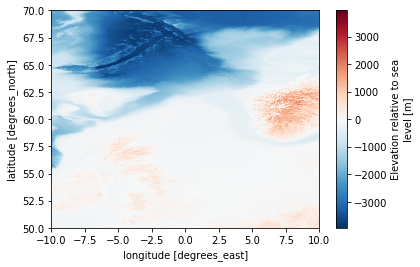

In [10]:
# plot the grid using xarray "plot" which defaults to matplotlib the "pcolormesh" type
subset.plot();

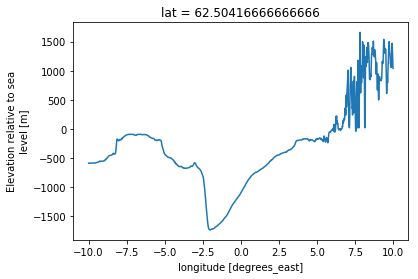

In [11]:
# plot a proflie across the grid at a given latitude
subset.sel(lat=62.5,method='nearest').plot.line();

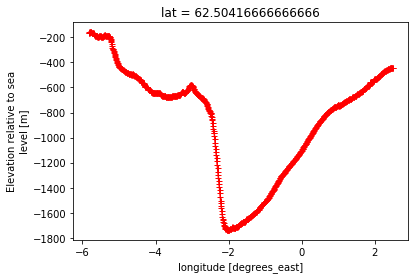

In [12]:
# you can do lots here, slice the array i.e. just present array items with an index between 500 and 800
# also, you can pass in matplotlib key word arguements (kwargs) setting line color and marker type (amongst others)
subset.sel(lat=62.5,method='nearest')[500:1500].plot.line(color='red', marker='+');

In [13]:
# export the DEM profile to a csv making sure the columns are order by lon,lat,depth ie x,y,z

# create a pandas dataframe for a given index value the latitude nearest 65 degrees)
df = subset.sel(lat=65,method='nearest').to_dataframe(name='z')

# we don't need an index for x,y,z data
df = df.reset_index()

# renmae the column headers in the pandas dataframe
df.columns = ['x','y','z']

# print the top 5 rows
df.head(5)

,x,y,z
0,-9.995833,64.995833,-734.0
1,-9.987500,64.995833,-738.0
2,-9.979167,64.995833,-741.0
3,-9.970833,64.995833,-745.0
4,-9.962500,64.995833,-748.0


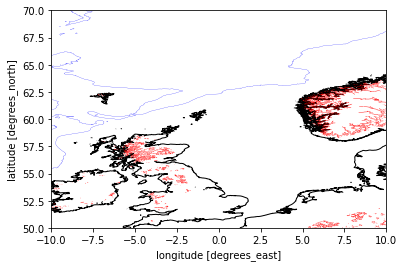

In [14]:
# get funky with key word arguements (kwargs), e.g. with specifying lists of arguements
# note the number of items needs to stay the same between arguements.
# there's plenty of functionality, e.g. list colours accepting different types of input
# So here, three elevation contours are specifed, with different colours applied, and different line weights
subset.plot.contour(colors=['blue','#000000','r'],levels=[-1000,0,500],linewidths=[0.2,1,0.2]);

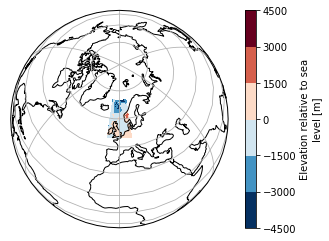

In [15]:
# up to now we've been using the plot method of the xarray data array, which under the hood calls create a matplotlib plot
# to use cartopy we to use matplotlib, which can be a little confusing to the uninitiated
# here we're going to plot using an orthographic projection (think globe)
# To be honest, I don't fully get the ins and outs but through trial and error, this seems to work

# this creates a 'GeoAxesSubplot' object which is a subtype of matplotlib's pyplot but
# becomes a 'geo' object when cartopy is imported.
# see I don't really get what's going on.
ax = plt.axes(projection=ccrs.Orthographic(-0, 60))

# this line calls the plot method of the dataarray and passes the 'GeoAxesSubplot' object
my_plot = subset.plot.contourf(ax=ax, transform=ccrs.PlateCarree());

# set the extent to global and add gridlines and coastlines
ax.set_global();
ax.gridlines();
ax.coastlines();

In [18]:
print('"ax" type = ' + str(type(ax)) + '\n' + '"my_plot type" _
      =' + str(type(my_plot)))

SyntaxError: EOL while scanning string literal (<ipython-input-18-bcbcf9b33c77>, line 1)

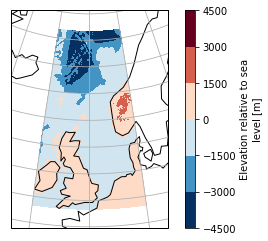

In [17]:
# zoom to a fixed extent
plt.figure()
ax = plt.axes(projection=ccrs.Orthographic(-0, 60));
subset.plot.contourf(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([-13, 13, 47, 72]);
ax.gridlines();
ax.coastlines();
plt.show()

In [ ]:
# plot a histogram of data values 
subset.plot.hist()

In [ ]:
# the 'Seaborn' library uses 
sns.palplot(sns.color_palette("cubehelix", 8))

In [ ]:
subset.plot.contourf(cmap="cubehelix",levels=10)

In [ ]:
subset.plot(cmap='viridis')

In [ ]:
xr.plot.pcolormesh(subset,cmap='viridis',levels=7)

In [ ]:
subset.plot.contourf(cmap='viridis')

In [ ]:
subset.plot.contour(cmap='viridis')